In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from src.dm import DFTemporalDataModule


dm = DFTemporalDataModule(batch_size=4)

dm.setup()

train: 8689
test: 2773


In [10]:
dl = dm.train_dataloader()
s1s, s2s, labels = next(iter(dl))

s1s.shape, s1s.dtype, s1s.max(), s1s.min(), s2s.shape, s2s.dtype, s2s.max(), s2s.min(), labels.shape

(torch.Size([4, 12, 2, 256, 256]),
 torch.float32,
 tensor(0.9882),
 tensor(-0.),
 torch.Size([4, 12, 3, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.),
 torch.Size([4, 256, 256]))

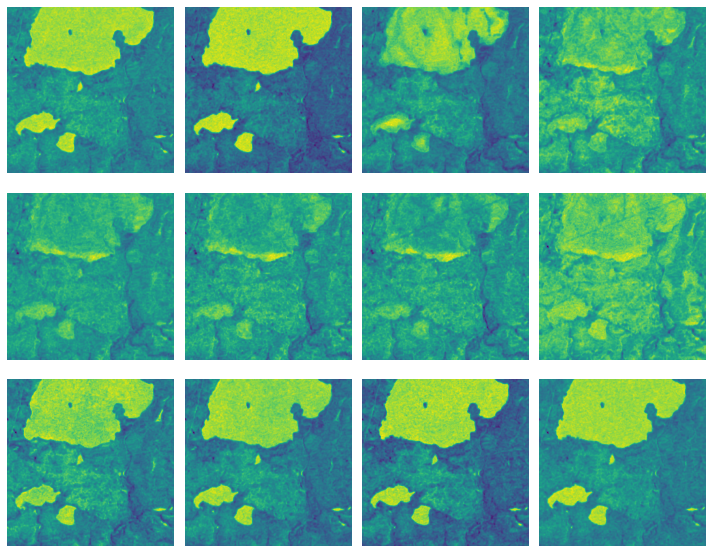

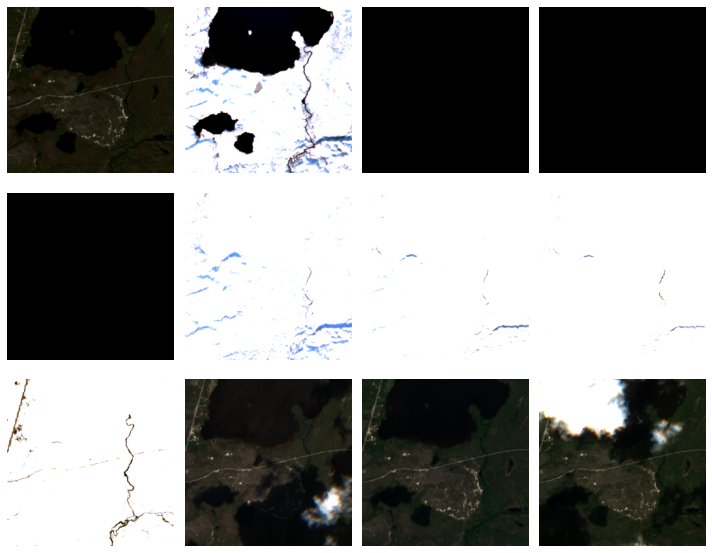

In [12]:
import matplotlib.pyplot as plt 

dl = dm.train_dataloader(shuffle=False)
# dl = dm.train_dataloader()
s1s, s2s, labels = next(iter(dl))

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(s1s[0][i*4+j][0])
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(s2s[0][i*4+j][:3,...].permute(1, 2, 0))
		# ax[i, j].imshow(s2s[0][i*4+j][-1], cmap='viridis')
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

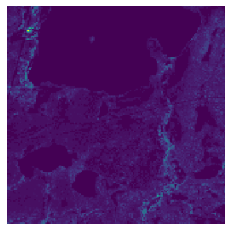

In [13]:
plt.imshow(labels[0])
plt.axis('off')
plt.show()

In [21]:
from src.module import UNetA
import torch 

hparams = {
	'encoder': 'resnet18',
	'pretrained': "imagenet",
    'embed_dim': 128,
    'n_heads': 1,
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetA(hparams)

# module
inputs = torch.randn(4, 12, 2, 256, 256), torch.randn(4, 12, 3, 256, 256)
out = module(*inputs)
out.shape

(64, 64, 128, 256, 512)
torch.Size([4, 1536, 128])
torch.Size([4, 1536, 128])
torch.Size([4, 1536, 128])
torch.Size([4, 1536, 128])
torch.Size([4, 1536, 128])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 128 for tensor number 1 in the list.

Overfit batches

In [7]:
import pytorch_lightning as pl
import torch

dm = DFModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-5
	},
}


module = UNetA(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 3.2 M 
3 | segmentation_head | SegmentationHead | 145   
4 | attn              | ModuleList       | 18.8 M
5 | attn_decoder      | ModuleList       | 583 M 
-------------------------------------------------------
628 M     Trainable params
0         Non-trainable params
628 M     Total params
1,256.473 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [8]:
dl = dm.train_dataloader(shuffle=False)
s1, s2, labels = next(iter(dl))
preds = module.predict(s1, s2)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([4, 256, 256]), torch.float32, tensor(-1.9410), tensor(6.3399))

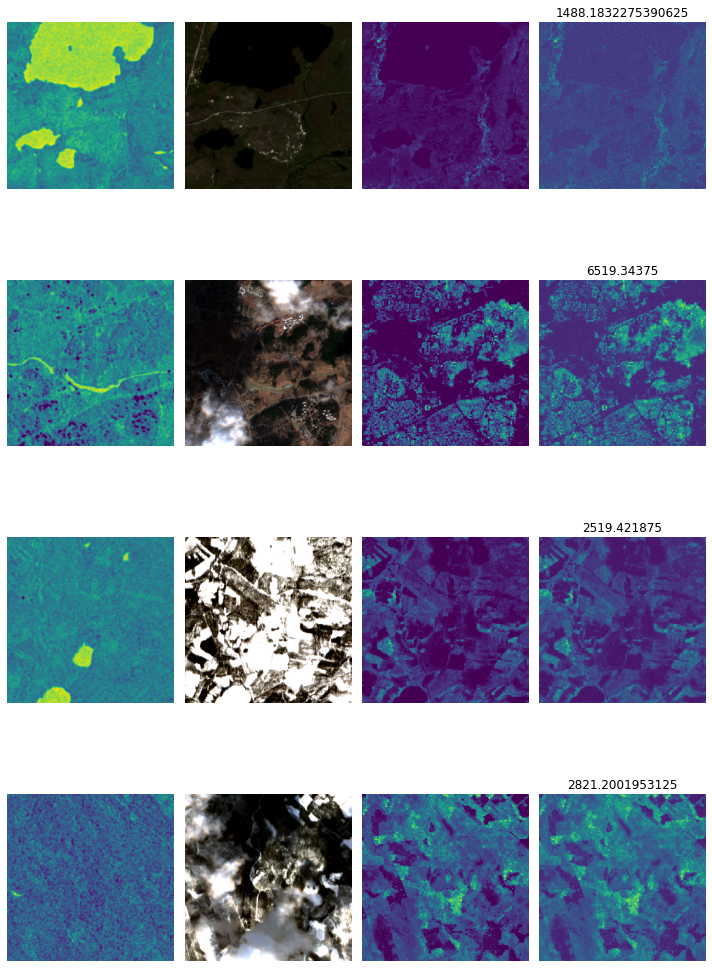

In [10]:
import torch 

fig, ax = plt.subplots(4, 4, figsize=(10, 15))
for i in range(4):
	ax[i, 0].imshow(s1[i][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
	ax[i, 3].imshow(preds[i])
	ax[i, 3].axis('off')
	# ax[i, 3].set_title(torch.sqrt(
    #         torch.sum((preds[i]*12905.3 - labels[i]*12905.3)**2)).item())
	ax[i, 3].set_title(torch.sqrt(
            torch.sum((preds[i]* 63.456604 - labels[i]* 63.456604)**2)).item())

plt.tight_layout()
plt.show()